In [1]:
using Dates
# using Revise
import PlotlyJS

include("../Sensors/Sensors.jl")
include("../PreProcessing/PreProcessing.jl")
include("../Utils/Helpers.jl")
include("../Utils/Visualizations.jl")
using .Sensors, .PreProcessing, .Visualizations, .Helpers;

WebIO._IJuliaInit()

## Load the data and format it

In [2]:
#= datafolder = "../../Data/Twitter/"
datafile = datafolder * "all_links_processed.json"
data = load_json(datafile) =#

datafolder = "../../Data/Twitter/COP26_processed_lightweight/"
datafiles = [file for file in readdir(datafolder) if occursin(".json", file)]
frames = [load_json(datafolder * file) for file in datafiles]
data = vcat(frames...)

data = data[.~ismissing.(data."domain"), :]

to_datetime = x -> DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS")
data."created_at" = to_datetime.(data."created_at");

## Define the partition, actors and actions

In [3]:
part_fun = cop_26_dates
actor_fun = follower_count
action_fun = trust_score

df = data |> part_fun |> action_fun |> actor_fun

actions = sort(unique(df.action))
actors = sort(unique(df.actor))
partitions = sort(unique(df.partition));

## Statistics on the data

PyPlot.Figure(PyObject <Figure size 640x480 with 1 Axes>)

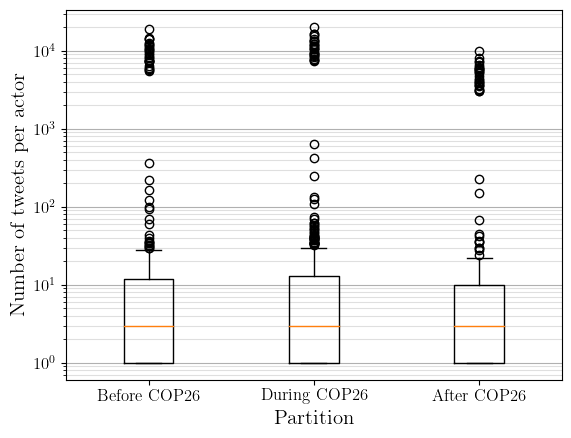

In [4]:
show(plot_actor_frequency(df, save=false, filename="../../Results/actor_frequency.pdf"))

In [5]:
plot_actor_wordcloud(df, Nactor=300, save=false, filename="../../Results/actor_wordcloud.svg")

mask size: 600×800, content area: 615² (36²/word)
set fontsize ∈ [8.0, 300]
set density = 0.5
⋯scale=39.7015427911813, density=0.5852894993536721	↑
⋯scale=36.69501077490383, density=0.5210754419216953	↑
⋯scale=35.65303073773036, density=0.5014473778123191	↑
fontsize ∈ [8.0, 45.239818077787945]
174 words(58%) are limited to the minimum font size.
gathering style: rt = 1, ellipse
gathering style: rt = 1, ellipse
▸1. scale = 28.45998935508883


┌ Info: nepoch: 1000, patient: 10
└ @ Stuffing.Trainer /Users/cyrilvallez/.julia/packages/Stuffing/oYQwL/src/fit.jl:482
┌ Info: @epoch 9(+2), 10(1) collisions, reposition nothing
└ @ Stuffing.Trainer /Users/cyrilvallez/.julia/packages/Stuffing/oYQwL/src/fit.jl:494
┌ Info: @epoch 10(+3), 14(2) collisions, reposition nothing
└ @ Stuffing.Trainer /Users/cyrilvallez/.julia/packages/Stuffing/oYQwL/src/fit.jl:494
┌ Info: @epoch 10, random move [91, 83]
└ @ Stuffing.Trainer /Users/cyrilvallez/.julia/packages/Stuffing/oYQwL/src/fit.jl:514


24 epochs


┌ Info: @epoch 11(+4), 10(1) collisions, reposition nothing
└ @ Stuffing.Trainer /Users/cyrilvallez/.julia/packages/Stuffing/oYQwL/src/fit.jl:494
┌ Info: @epoch 11, random move [9]
└ @ Stuffing.Trainer /Users/cyrilvallez/.julia/packages/Stuffing/oYQwL/src/fit.jl:514


PyPlot.Figure(PyObject <Figure size 640x480 with 1 Axes>)

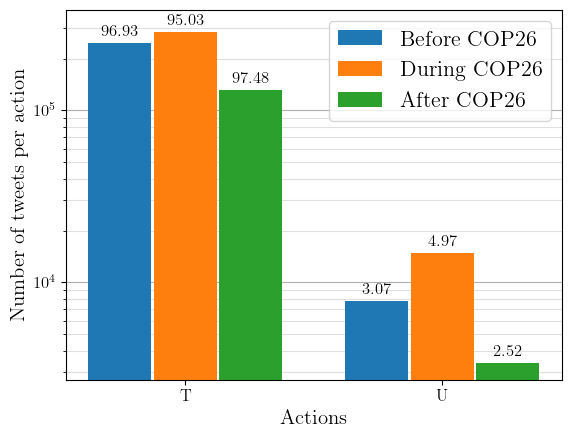

In [6]:
show(plot_action_frequency(df, save=false, filename="../../Results/action_frequency.pdf"))

## Compute influence graph

In [7]:
hours = 2
minutes = 0;

In [8]:
total_min = hours*60 + minutes

# tsg = TimeSeriesGenerator(Minute(total_min), standardize=false)
tsg = TimeSeriesGenerator(Minute(total_min), standardize=true)

# ig = InfluenceGraphGenerator()
# ig = InfluenceGraphGenerator(SMeasure)
ig = InfluenceGraphGenerator(JointDistanceDistribution, Nsurro=100, alpha=0.001, seed=1234)
# ig = InfluenceGraphGenerator(TransferEntropy)

cuttoff = 0.5
icg = InfluenceCascadeGenerator(cuttoff)
# icg = InfluenceCascadeGenerator(WithoutCuttoff)

InfluenceCascadeGenerator(0.5, true)

In [9]:
time_series = observe(df, tsg)
influence_graphs = observe(time_series, ig);

## Compute influence cascade

In [10]:
influence_cascades = observe.(influence_graphs, Ref(icg))

edge_types = [string(n1, " to ", n2) for n1 in actions for n2 in actions]
push!(edge_types, "Any Edge");

## Plot influence graph

In [11]:
partition = "During COP26"
edge = "Any Edge";

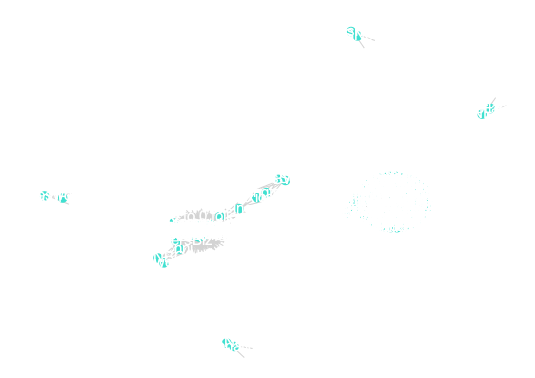

In [12]:
simplifier = make_simplifier(edge, cuttoff, edge_types)
partition_index = (1:length(partitions))[findfirst(partition .== partitions)]
	
# In this case we plot the graph on a world map
if actor_fun == country
	PlotlyJS.plot(map_plot(df)...)
# In this case we plot a simple graph of the actors
else
	plot_graph(influence_graphs[partition_index], df, simplifier)
end

PyPlot.Figure(PyObject <Figure size 640x480 with 1 Axes>)

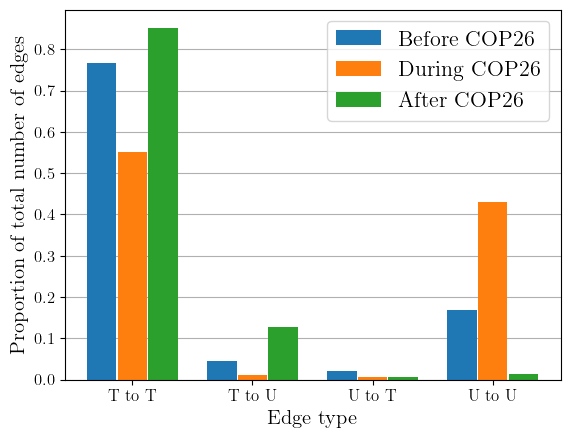

In [13]:
show(plot_edge_types(influence_graphs, df, cuttoff, log=false))

## Plot cascades and statistics

In [14]:
partition_index = 3
influencer_indices = [ic.root for ic in influence_cascades[partition_index]]
influencers = sort(actors[influencer_indices])

8-element Vector{String}:
 "BBCScotlandNews"
 "CBSNews"
 "MailOnline"
 "YahooFinance"
 "axios"
 "cnni"
 "thenation"
 "washingtonpost"

In [15]:
influencer_node1 = influencers[4]

PlotlyJS.plot(plot_cascade_sankey(influence_cascades[partition_index][findfirst(influencer_node1 .== influencers)], df)...)
# PlotlyJS.savefig(PlotlyJS.plot(plot_cascade_sankey(influence_cascades[partition_index][findfirst(influencer_node1 .== influencers)], df)...), "../../Results/cascade.pdf")

data: [
  "sankey with fields arrangement, link, node, type, and valueformat"
]

layout: "layout with fields font, margin, template, and title"

PyPlot.Figure(PyObject <Figure size 640x480 with 1 Axes>)

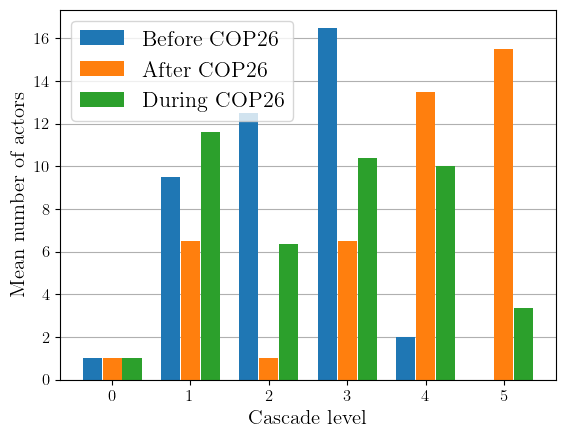

In [16]:
show(plot_actors_per_level(influence_cascades, df, log=false))

PyPlot.Figure(PyObject <Figure size 640x480 with 1 Axes>)

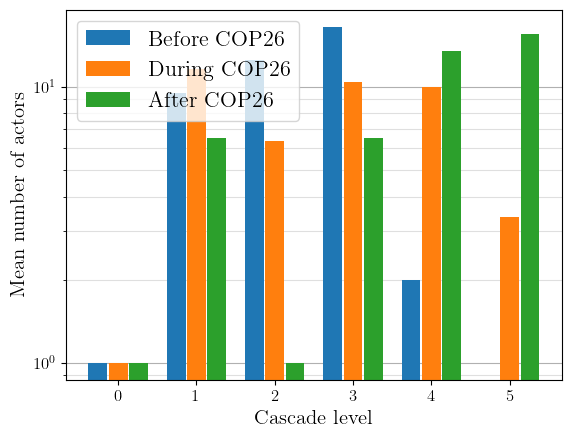

In [17]:
show(plot_actors_per_level(influence_cascades, df, save=false, filename="../../Results/mean_actor_cascade.pdf", log=true, inner_spacing=0.02, reorder=[2, 3, 1]))